In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as ps
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
import pandas_datareader
from datetime import date

# In this notebook, we will use Logistic Regression techniques to perform a prediction on whether a stock will move up or down on the next day

## Load in initial datasets using pandas_datareader with yahoo finance

In [103]:
# Load in intitial datasets
ticker = 'spy'
vixtick = '^vix'
tenyrtick = '^tnx'
startdate = '2006-01-01'

spy = pandas_datareader.DataReader(ticker.lower(), 'yahoo', start=startdate, end = date.today().strftime("%Y-%m-%d"))
spy.reset_index(inplace=True)

vix = pandas_datareader.DataReader(vixtick.lower(), 'yahoo', start=startdate, end = date.today().strftime("%Y-%m-%d"))
vix.reset_index(inplace=True)

tenyr = pandas_datareader.DataReader(tenyrtick.lower(), 'yahoo', start=startdate, end = date.today().strftime("%Y-%m-%d"))
tenyr.reset_index(inplace=True)

## Data cleaning

In [104]:
# Convert date column to datetime from string so that it can easily be operated on
spy['Date'] = pd.to_datetime(spy['Date'])
vix['Date'] = pd.to_datetime(vix['Date'])
tenyr['Date'] = pd.to_datetime(tenyr['Date'])

In [105]:
# Clean spy data 
spy.rename(columns={'Adj Close': 'AdjClose'}, inplace=True)
spy.drop(['High', 'Low', 'Open', 'Close', 'Volume'], axis=1, inplace=True)

In [106]:
# Clean and relabel vix data 
vix.rename(columns={'Adj Close': 'VIX_AdjClose'}, inplace=True)
vix.drop(['Volume', 'High', 'Low', 'Close', 'Open', 'Volume'], axis=1, inplace=True)

In [107]:
# Clean and relabel bond data 
tenyr.rename(columns={'Adj Close': 'TenYr_AdjClose'}, inplace=True)
tenyr.drop(['High', 'Low', 'Volume', 'Open', 'Close'], axis=1, inplace=True)

In [108]:
# Get the means of columns with any missing values 
# Could make this a mean within 10 values surrounding possibly
def get_missing_values(df):
    values = {}
    for feat in df.columns:
        if df[feat].isna().any():
            values[feat] = round(df[feat].mean(),3)
    return values

values = get_missing_values(spy)
values

{}

In [109]:
len(vix)

4262

In [110]:
len(spy)

4262

<AxesSubplot:>

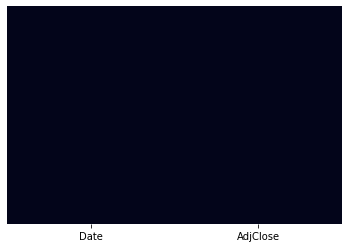

In [111]:
# Fill empty values and display heatmap
spy.fillna(value=values, inplace=True)
sns.heatmap(spy.isnull(), yticklabels=False, cbar=False)

<AxesSubplot:>

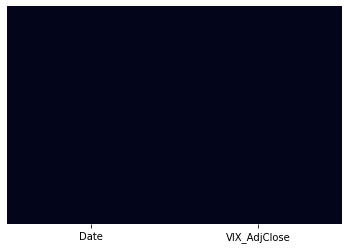

In [112]:
# Fill empty values and display heatmap
vix.fillna(value=values, inplace=True)
sns.heatmap(vix.isnull(), yticklabels=False, cbar=False)

In [113]:
# Summary of columns with null values 
Sum = spy.isnull().sum()
Percentage = (spy.isnull().sum()/spy.isnull().count())

pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage'])

,Sum,Percentage
Date,0,0.0
AdjClose,0,0.0


In [114]:
# Join dataframes together based on date 
spyvix = spy.merge(vix, how='inner', on=['Date'])
df = spyvix.merge(tenyr, how='inner', on=['Date'])

In [115]:
df.head()

,Date,AdjClose,VIX_AdjClose,TenYr_AdjClose
0,2006-01-03,91.405472,11.14,4.370
1,2006-01-04,91.838310,11.37,4.356
2,2006-01-05,91.896011,11.31,4.356
3,2006-01-06,92.660767,11.00,4.379
4,2006-01-09,92.898849,11.13,4.379


In [116]:
df.describe()

,AdjClose,VIX_AdjClose,TenYr_AdjClose
count,4258.000000,4258.000000,4258.000000
mean,189.667391,19.865773,2.674568
std,106.705978,9.261797,1.067913
min,52.195717,9.140000,0.499000
25%,102.881016,13.542500,1.895250
50%,164.878120,17.330000,2.516500
75%,255.357430,23.270000,3.370500
max,472.242310,82.690002,5.248000


In [117]:
# Get series' of 3 weeks days ago days of lagging prices for logistic regression
for i in range(1, 31):
    df['Trailing ' + str(i) + ' day(s)'] = df['AdjClose'].shift(i)

In [118]:
# Create NextDayChange Feature (y value to predict)
df['NextDayChange'] = ((df['AdjClose'].shift(-1) / df['AdjClose'] - 1) * 100).fillna(0)

In [119]:
df

,Date,AdjClose,VIX_AdjClose,TenYr_AdjClose,Trailing 1 day(s),Trailing 2 day(s),Trailing 3 day(s),Trailing 4 day(s),Trailing 5 day(s),Trailing 6 day(s),...,Trailing 22 day(s),Trailing 23 day(s),Trailing 24 day(s),Trailing 25 day(s),Trailing 26 day(s),Trailing 27 day(s),Trailing 28 day(s),Trailing 29 day(s),Trailing 30 day(s),NextDayChange
0,2006-01-03,91.405472,11.140000,4.370,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.473537
1,2006-01-04,91.838310,11.370000,4.356,91.405472,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.062829
2,2006-01-05,91.896011,11.310000,4.356,91.838310,91.405472,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.832196
3,2006-01-06,92.660767,11.000000,4.379,91.896011,91.838310,91.405472,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256940
4,2006-01-09,92.898849,11.130000,4.379,92.660767,91.896011,91.838310,91.405472,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,2022-11-30,407.679993,20.580000,3.703,395.230011,395.910004,402.329987,402.420013,399.899994,394.589996,...,389.019989,379.980011,382.019989,384.920013,378.869995,374.290009,365.410004,368.500000,371.130005,-0.073584
4254,2022-12-01,407.380005,19.840000,3.529,407.679993,395.230011,395.910004,402.329987,402.420013,399.899994,...,386.209991,389.019989,379.980011,382.019989,384.920013,378.869995,374.290009,365.410004,368.500000,-0.115372
4255,2022-12-02,406.910004,19.059999,3.506,407.380005,407.679993,395.230011,395.910004,402.329987,402.420013,...,384.519989,386.209991,389.019989,379.980011,382.019989,384.920013,378.869995,374.290009,365.410004,-1.798925
4256,2022-12-05,399.589996,20.750000,3.599,406.910004,407.380005,407.679993,395.230011,395.910004,402.329987,...,374.869995,384.519989,386.209991,389.019989,379.980011,382.019989,384.920013,378.869995,374.290009,-1.441480


In [120]:
# 1 represents up, 0 represents down 
df['Direction'] = [1 if i > 0 else 0 for i in df['NextDayChange']]
# Shift the direction back 1, so that Direction in a given row corresponds to where it is going tomorrow
df['Direction'] = df['Direction'].shift(-1)

df.tail()

,Date,AdjClose,VIX_AdjClose,TenYr_AdjClose,Trailing 1 day(s),Trailing 2 day(s),Trailing 3 day(s),Trailing 4 day(s),Trailing 5 day(s),Trailing 6 day(s),...,Trailing 23 day(s),Trailing 24 day(s),Trailing 25 day(s),Trailing 26 day(s),Trailing 27 day(s),Trailing 28 day(s),Trailing 29 day(s),Trailing 30 day(s),NextDayChange,Direction
4253,2022-11-30,407.679993,20.580000,3.703,395.230011,395.910004,402.329987,402.420013,399.899994,394.589996,...,379.980011,382.019989,384.920013,378.869995,374.290009,365.410004,368.500000,371.130005,-0.073584,0.0
4254,2022-12-01,407.380005,19.840000,3.529,407.679993,395.230011,395.910004,402.329987,402.420013,399.899994,...,389.019989,379.980011,382.019989,384.920013,378.869995,374.290009,365.410004,368.500000,-0.115372,0.0
4255,2022-12-02,406.910004,19.059999,3.506,407.380005,407.679993,395.230011,395.910004,402.329987,402.420013,...,386.209991,389.019989,379.980011,382.019989,384.920013,378.869995,374.290009,365.410004,-1.798925,0.0
4256,2022-12-05,399.589996,20.750000,3.599,406.910004,407.380005,407.679993,395.230011,395.910004,402.329987,...,384.519989,386.209991,389.019989,379.980011,382.019989,384.920013,378.869995,374.290009,-1.441480,0.0
4257,2022-12-06,393.829987,22.170000,3.513,399.589996,406.910004,407.380005,407.679993,395.230011,395.910004,...,374.869995,384.519989,386.209991,389.019989,379.980011,382.019989,384.920013,378.869995,0.000000,NaN


Text(0.5, 1.0, 'Direction Classifier')

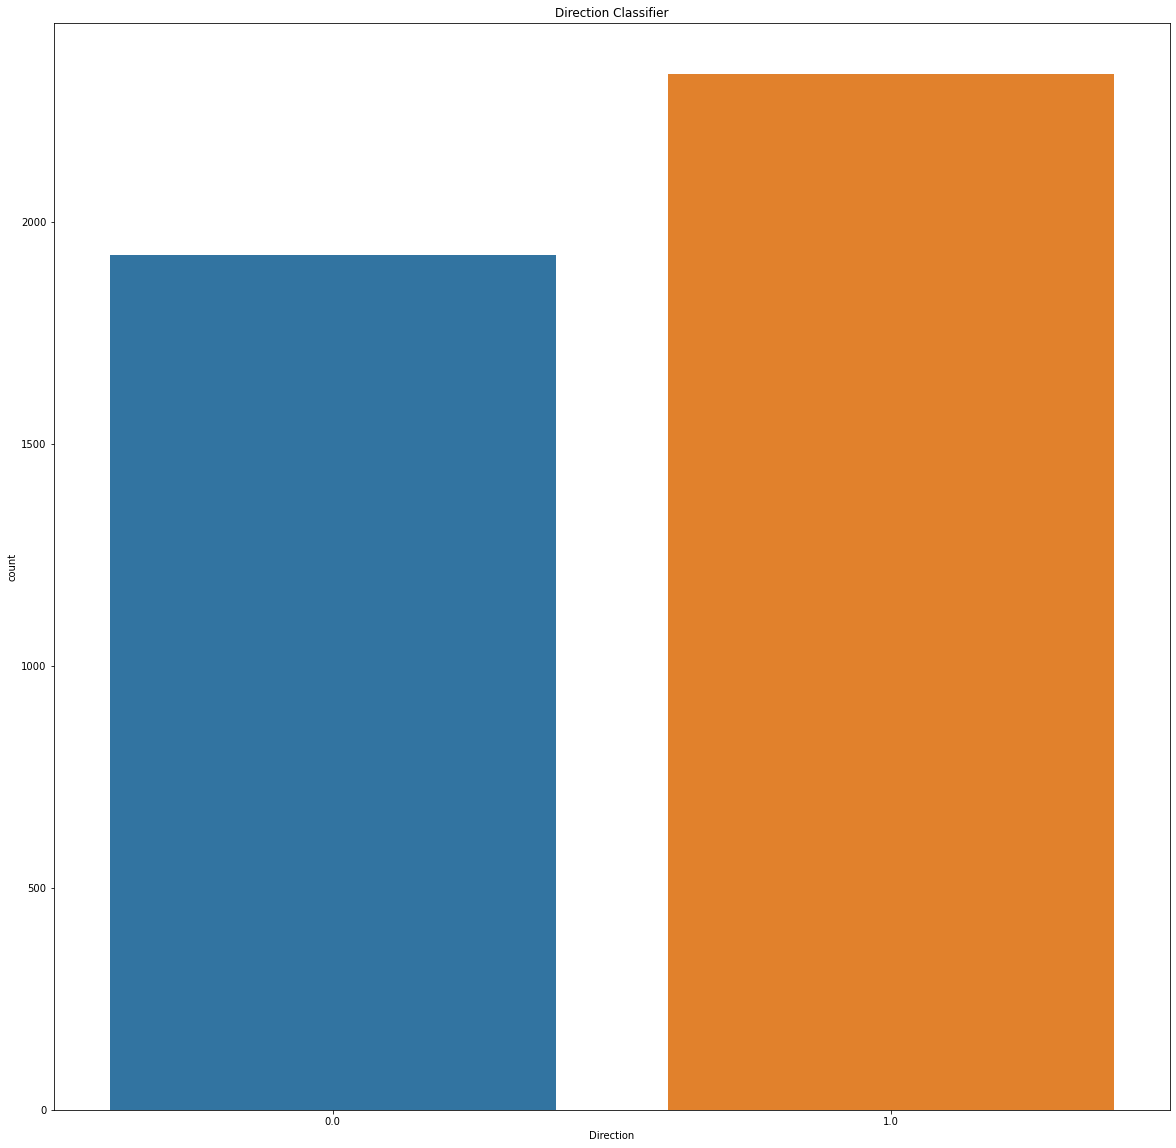

In [121]:
# Plot the number of "up days" compared to the number of "down days"
plt.figure(figsize=(20,20))
sns.countplot(data=df, x='Direction').set_title("Direction Classifier")

In [122]:
df['Direction'].value_counts()

1.0    2332
0.0    1925
Name: Direction, dtype: int64

In [123]:
# Drop rows where no data exists
df.dropna(inplace=True)

Text(0, 0.5, 'correlation')

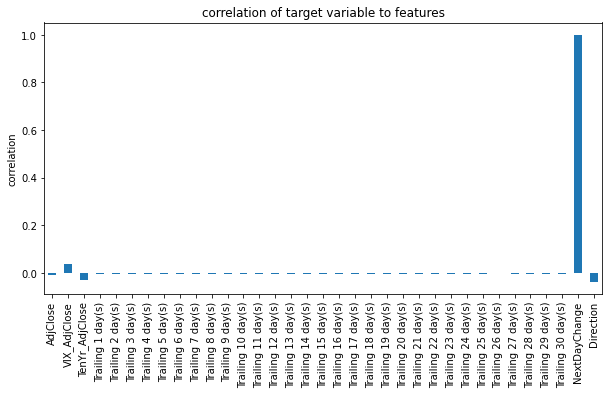

In [124]:
# Plot correlation of the NextDayChange to current features
plt.figure(figsize=(10,5))
ax = df.corr()['NextDayChange'].plot(kind='bar',title='correlation of target variable to features')
ax.set_ylabel('correlation')

<AxesSubplot:>

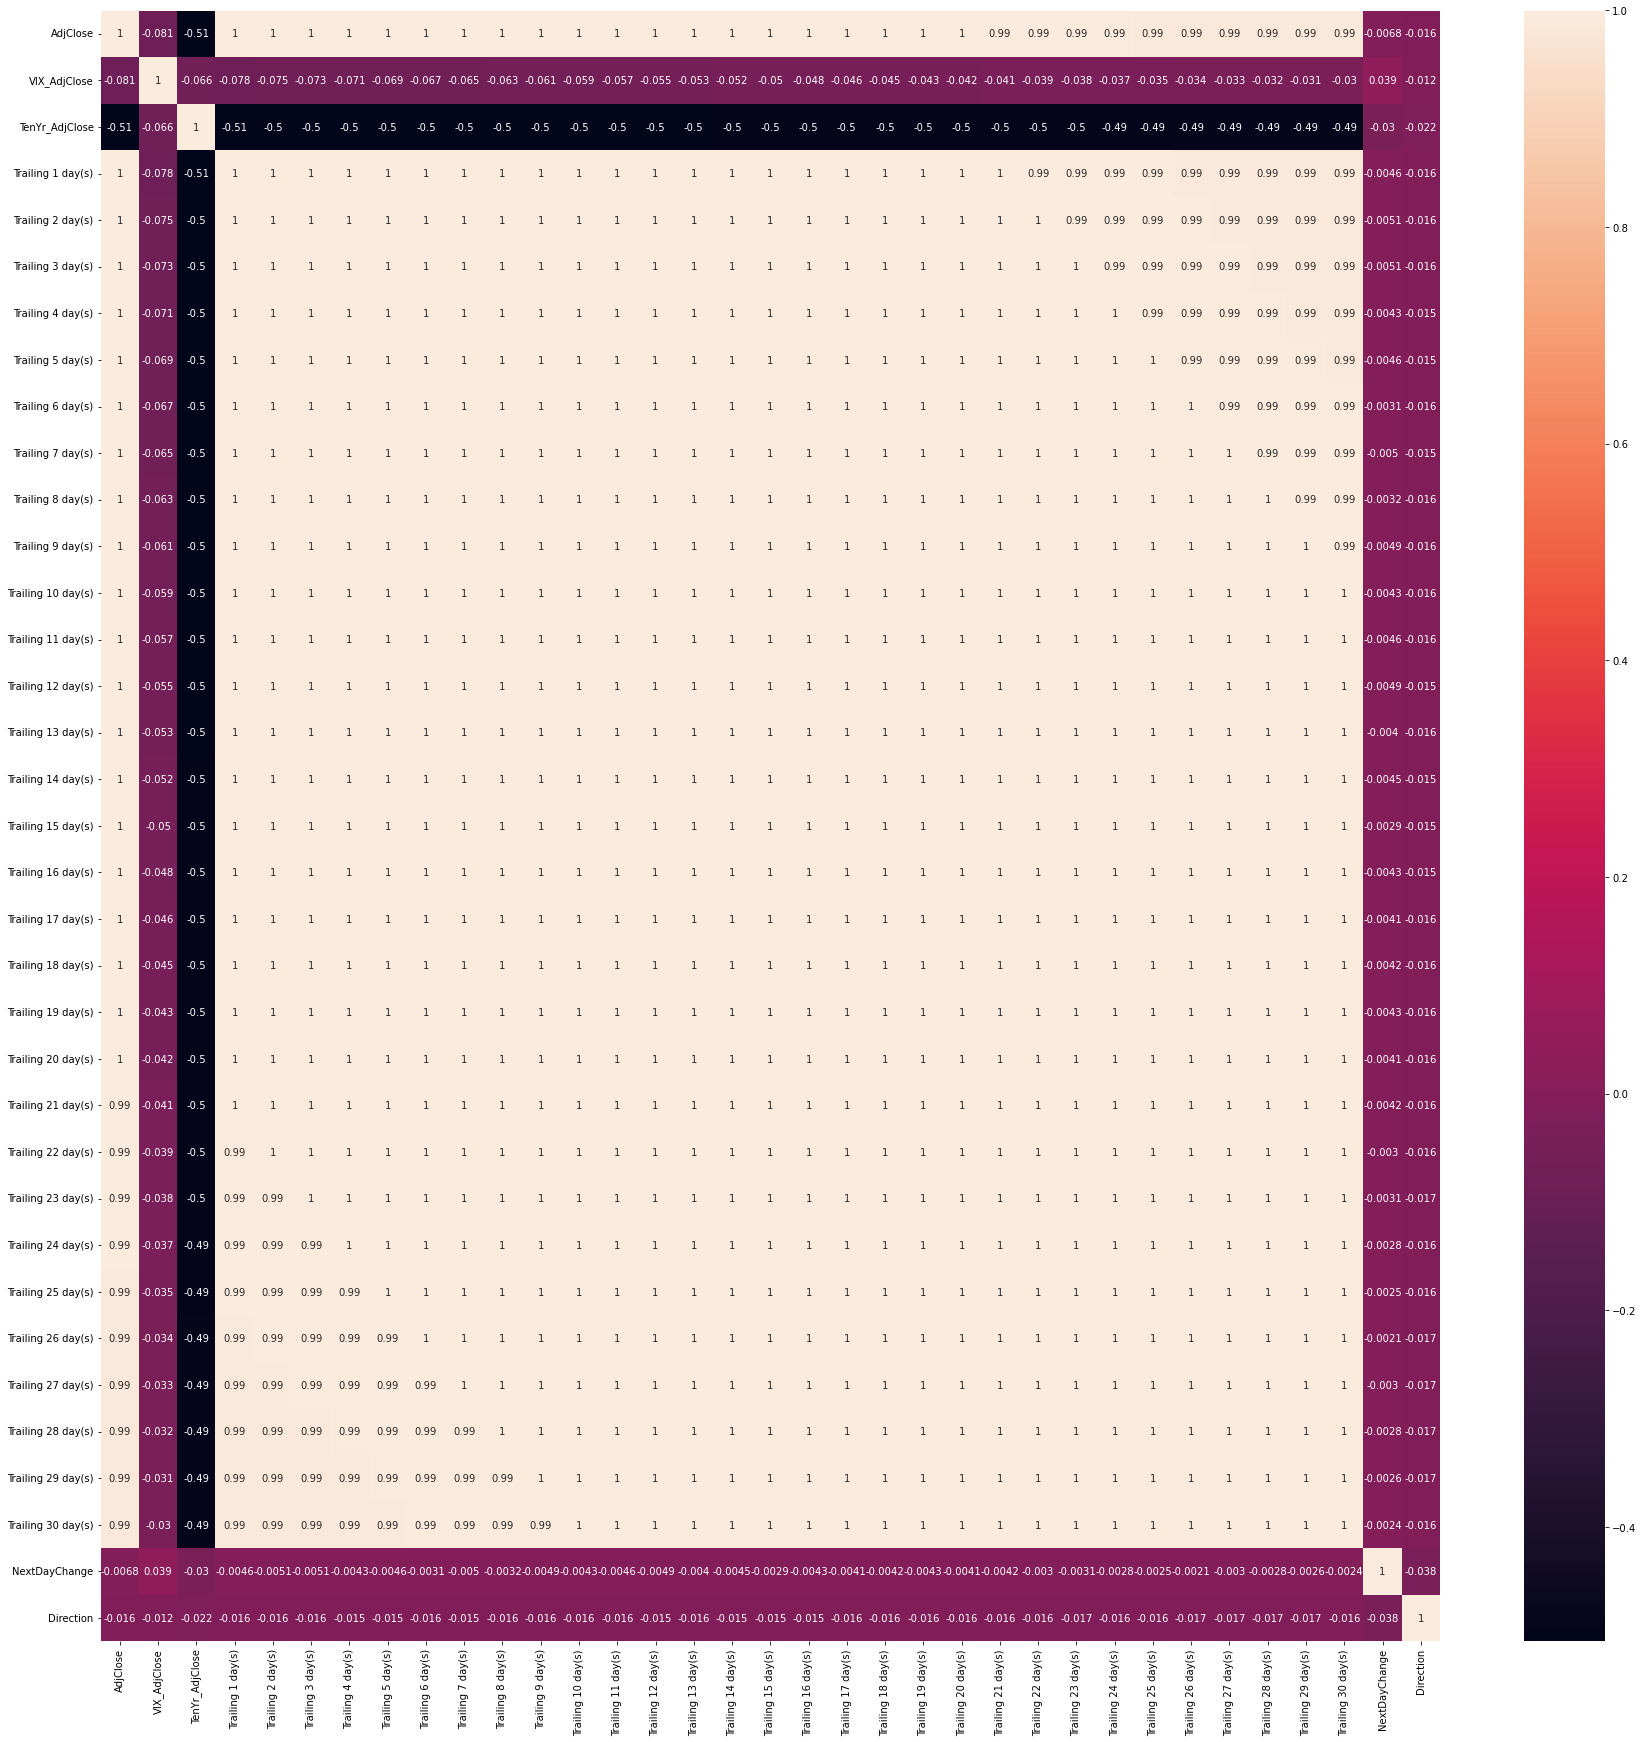

In [125]:
plt.figure(figsize=(30, 30))
sns.heatmap(df.corr(), annot=True)

In [126]:
# Create X and y data
# Only want to use 10 days of lagging data and vix close for inputs
X = df.drop(axis=1, columns=['Date', 'NextDayChange', 'Direction'])
# Outputs should only be direction
y = df.Direction

In [127]:
X

,AdjClose,VIX_AdjClose,TenYr_AdjClose,Trailing 1 day(s),Trailing 2 day(s),Trailing 3 day(s),Trailing 4 day(s),Trailing 5 day(s),Trailing 6 day(s),Trailing 7 day(s),...,Trailing 21 day(s),Trailing 22 day(s),Trailing 23 day(s),Trailing 24 day(s),Trailing 25 day(s),Trailing 26 day(s),Trailing 27 day(s),Trailing 28 day(s),Trailing 29 day(s),Trailing 30 day(s)
30,92.487617,12.310000,4.606,92.162971,91.196228,91.362175,91.196228,91.347771,90.525299,91.333344,...,92.581398,92.833885,92.920471,93.288391,92.992615,92.898849,92.660767,91.896011,91.838310,91.405472
31,93.180153,11.480000,4.596,92.487617,92.162971,91.196228,91.362175,91.196228,91.347771,90.525299,...,92.213478,92.581398,92.833885,92.920471,93.288391,92.992615,92.898849,92.660767,91.896011,91.838310
32,92.927666,12.010000,4.541,93.180153,92.487617,92.162971,91.196228,91.362175,91.196228,91.347771,...,92.566963,92.213478,92.581398,92.833885,92.920471,93.288391,92.992615,92.898849,92.660767,91.896011
33,92.696800,12.410000,4.563,92.927666,93.180153,92.487617,92.162971,91.196228,91.362175,91.196228,...,90.878845,92.566963,92.213478,92.581398,92.833885,92.920471,93.288391,92.992615,92.898849,92.660767
34,93.259583,11.880000,4.531,92.696800,92.927666,93.180153,92.487617,92.162971,91.196228,91.362175,...,91.203438,90.878845,92.566963,92.213478,92.581398,92.833885,92.920471,93.288391,92.992615,92.898849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4252,395.230011,21.889999,3.748,395.910004,402.329987,402.420013,399.899994,394.589996,396.029999,394.239990,...,389.019989,379.980011,382.019989,384.920013,378.869995,374.290009,365.410004,368.500000,371.130005,366.820007
4253,407.679993,20.580000,3.703,395.230011,395.910004,402.329987,402.420013,399.899994,394.589996,396.029999,...,386.209991,389.019989,379.980011,382.019989,384.920013,378.869995,374.290009,365.410004,368.500000,371.130005
4254,407.380005,19.840000,3.529,407.679993,395.230011,395.910004,402.329987,402.420013,399.899994,394.589996,...,384.519989,386.209991,389.019989,379.980011,382.019989,384.920013,378.869995,374.290009,365.410004,368.500000
4255,406.910004,19.059999,3.506,407.380005,407.679993,395.230011,395.910004,402.329987,402.420013,399.899994,...,374.869995,384.519989,386.209991,389.019989,379.980011,382.019989,384.920013,378.869995,374.290009,365.410004


In [128]:
y

30      0.0
31      0.0
32      1.0
33      0.0
34      1.0
       ... 
4252    0.0
4253    0.0
4254    0.0
4255    0.0
4256    0.0
Name: Direction, Length: 4227, dtype: float64

In [129]:
# Create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

In [152]:
X

,AdjClose,VIX_AdjClose,TenYr_AdjClose,Trailing 1 day(s),Trailing 2 day(s),Trailing 3 day(s),Trailing 4 day(s),Trailing 5 day(s),Trailing 6 day(s),Trailing 7 day(s),...,Trailing 21 day(s),Trailing 22 day(s),Trailing 23 day(s),Trailing 24 day(s),Trailing 25 day(s),Trailing 26 day(s),Trailing 27 day(s),Trailing 28 day(s),Trailing 29 day(s),Trailing 30 day(s)
30,92.487617,12.310000,4.606,92.162971,91.196228,91.362175,91.196228,91.347771,90.525299,91.333344,...,92.581398,92.833885,92.920471,93.288391,92.992615,92.898849,92.660767,91.896011,91.838310,91.405472
31,93.180153,11.480000,4.596,92.487617,92.162971,91.196228,91.362175,91.196228,91.347771,90.525299,...,92.213478,92.581398,92.833885,92.920471,93.288391,92.992615,92.898849,92.660767,91.896011,91.838310
32,92.927666,12.010000,4.541,93.180153,92.487617,92.162971,91.196228,91.362175,91.196228,91.347771,...,92.566963,92.213478,92.581398,92.833885,92.920471,93.288391,92.992615,92.898849,92.660767,91.896011
33,92.696800,12.410000,4.563,92.927666,93.180153,92.487617,92.162971,91.196228,91.362175,91.196228,...,90.878845,92.566963,92.213478,92.581398,92.833885,92.920471,93.288391,92.992615,92.898849,92.660767
34,93.259583,11.880000,4.531,92.696800,92.927666,93.180153,92.487617,92.162971,91.196228,91.362175,...,91.203438,90.878845,92.566963,92.213478,92.581398,92.833885,92.920471,93.288391,92.992615,92.898849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4252,395.230011,21.889999,3.748,395.910004,402.329987,402.420013,399.899994,394.589996,396.029999,394.239990,...,389.019989,379.980011,382.019989,384.920013,378.869995,374.290009,365.410004,368.500000,371.130005,366.820007
4253,407.679993,20.580000,3.703,395.230011,395.910004,402.329987,402.420013,399.899994,394.589996,396.029999,...,386.209991,389.019989,379.980011,382.019989,384.920013,378.869995,374.290009,365.410004,368.500000,371.130005
4254,407.380005,19.840000,3.529,407.679993,395.230011,395.910004,402.329987,402.420013,399.899994,394.589996,...,384.519989,386.209991,389.019989,379.980011,382.019989,384.920013,378.869995,374.290009,365.410004,368.500000
4255,406.910004,19.059999,3.506,407.380005,407.679993,395.230011,395.910004,402.329987,402.420013,399.899994,...,374.869995,384.519989,386.209991,389.019989,379.980011,382.019989,384.920013,378.869995,374.290009,365.410004


In [154]:
y

30      0.0
31      0.0
32      1.0
33      0.0
34      1.0
       ... 
4252    0.0
4253    0.0
4254    0.0
4255    0.0
4256    0.0
Name: Direction, Length: 4227, dtype: float64

In [130]:
X_train

,AdjClose,VIX_AdjClose,TenYr_AdjClose,Trailing 1 day(s),Trailing 2 day(s),Trailing 3 day(s),Trailing 4 day(s),Trailing 5 day(s),Trailing 6 day(s),Trailing 7 day(s),...,Trailing 21 day(s),Trailing 22 day(s),Trailing 23 day(s),Trailing 24 day(s),Trailing 25 day(s),Trailing 26 day(s),Trailing 27 day(s),Trailing 28 day(s),Trailing 29 day(s),Trailing 30 day(s)
567,102.893753,22.360001,3.558,102.999008,102.946358,103.059174,102.803452,102.735786,99.246323,98.900414,...,97.066223,98.076424,100.149330,99.520729,99.902374,100.141869,102.424240,103.434502,103.539284,102.768486
4132,407.776215,23.959999,3.029,412.258362,408.341461,407.101898,413.894562,406.159882,409.471893,411.782379,...,394.835510,407.895203,410.344513,425.466797,412.893005,411.008911,408.549683,424.227264,413.775543,412.615356
1828,133.084091,12.060000,1.721,133.410950,132.975159,131.366104,130.913513,130.033569,130.620209,130.092209,...,130.075195,129.891632,130.183640,129.691422,129.140747,128.907043,128.731873,127.588821,126.912987,126.495857
368,111.537537,15.750000,5.138,112.596962,111.974625,113.552689,113.271149,113.404495,112.762909,112.047394,...,112.453110,112.438347,112.526848,112.585892,111.612106,111.833420,111.073608,111.044067,111.287575,110.343285
2732,194.813614,14.480000,2.222,195.110474,194.624741,192.582977,191.719513,187.581970,187.788849,188.652328,...,191.593567,192.223190,191.971344,193.419495,194.085037,193.950150,193.095657,194.085037,194.552811,193.095657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3365,266.342712,16.920000,2.296,269.637268,270.468018,268.051331,269.835510,271.591400,269.099091,267.532135,...,275.867767,276.481354,274.017395,273.781372,273.243439,273.913605,273.734253,273.913605,272.072876,272.148346
1129,81.653214,34.540001,2.951,82.436356,85.062653,85.331635,84.975647,86.407494,86.676476,88.132004,...,84.659904,86.108551,87.202904,84.376457,84.888229,84.801590,85.903847,84.667740,87.990234,88.494102
2544,168.095612,24.110001,1.778,165.305481,161.966263,164.100891,164.242569,164.233734,166.474640,169.707581,...,169.999969,167.254120,171.532242,170.159317,169.991028,171.877670,176.102661,178.352402,178.051285,180.575638
3636,298.620514,35.119999,0.697,300.336945,300.221344,301.473572,295.780518,293.044769,289.576874,307.291931,...,286.031952,281.253967,284.172821,275.772858,274.510864,271.264618,276.148529,281.764557,281.706757,277.121460


In [131]:
y_train

567     1.0
4132    0.0
1828    1.0
368     0.0
2732    0.0
       ... 
3365    0.0
1129    0.0
2544    0.0
3636    1.0
2605    1.0
Name: Direction, Length: 3381, dtype: float64

In [132]:
lr = LogisticRegression(random_state = 2)
lr.fit(X_train, y_train)

C:\Users\embui\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=2)

### View test results

In [133]:
train_accuracy = lr.score(X_train, y_train)
test_accuracy = lr.score(X_test, y_test)
print('Accuracy in Train set   : {:.2f}'.format(train_accuracy), 
      'Accuracy in Test  set   : {:.2f}'.format(test_accuracy), sep='\n')

Accuracy in Train set   : 0.55
Accuracy in Test  set   : 0.55


In [150]:
# View importance
results = permutation_importance(lr, X, y, scoring='accuracy')
importance = results.importances_mean
print(importance)

for i, v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (i, v))


[0.03723681 0.00354862 0.00326473 0.0429146  0.04599006 0.04565886
 0.03894015 0.0397445  0.03392477 0.03983913 0.04986988 0.04040691
 0.04968062 0.0181216  0.03969718 0.04636858 0.03898746 0.01807428
 0.02682754 0.04882896 0.0365744  0.03070736 0.05034303 0.03841968
 0.03912941 0.05043766 0.03770996 0.03605394 0.04949137 0.03605394
 0.04286728 0.01991956 0.03491838]
Feature: 0, Score: 0.03724
Feature: 1, Score: 0.00355
Feature: 2, Score: 0.00326
Feature: 3, Score: 0.04291
Feature: 4, Score: 0.04599
Feature: 5, Score: 0.04566
Feature: 6, Score: 0.03894
Feature: 7, Score: 0.03974
Feature: 8, Score: 0.03392
Feature: 9, Score: 0.03984
Feature: 10, Score: 0.04987
Feature: 11, Score: 0.04041
Feature: 12, Score: 0.04968
Feature: 13, Score: 0.01812
Feature: 14, Score: 0.03970
Feature: 15, Score: 0.04637
Feature: 16, Score: 0.03899
Feature: 17, Score: 0.01807
Feature: 18, Score: 0.02683
Feature: 19, Score: 0.04883
Feature: 20, Score: 0.03657
Feature: 21, Score: 0.03071
Feature: 22, Score: 0.05

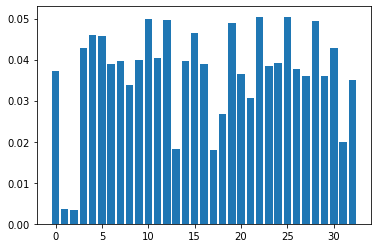

In [151]:
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [134]:
predictions = lr.predict(X_test)

In [101]:
predictions

array([1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
       0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 0.

In [99]:
confidence = lr.predict_proba(X_test)

In [100]:
confidence

array([[0.4626341 , 0.5373659 ],
       [0.44713834, 0.55286166],
       [0.509844  , 0.490156  ],
       ...,
       [0.48481797, 0.51518203],
       [0.50387095, 0.49612905],
       [0.36989667, 0.63010333]])

## Evaluate and validate Results

In [93]:
# Let's see what % of our predictions were up vs down 
num_up = np.count_nonzero(predictions)
num_down = predictions.size - np.count_nonzero(predictions)

In [94]:
# View results
num_up

736

In [95]:
num_down

110

Text(0, 0.5, 'Number of Predictions')

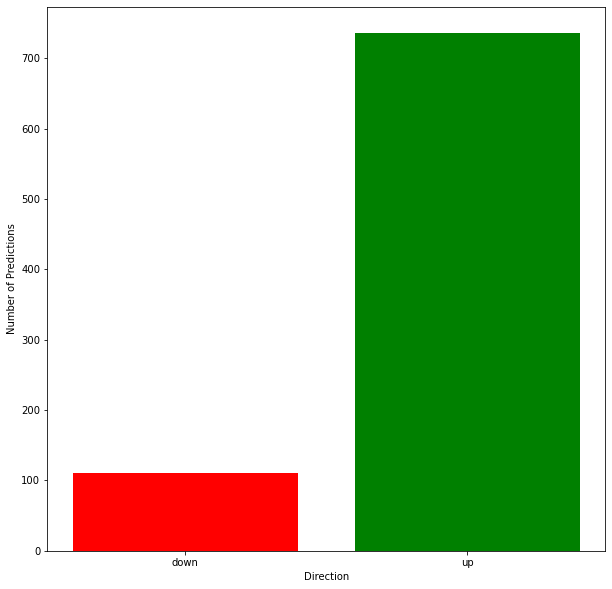

In [96]:
percent_up = num_up / predictions.size
percent_down = num_down / predictions.size
# Plot the number of "up days" compared to the number of "down days"
plt.figure(figsize=(10,10))
plt.bar(['down', 'up'], [num_down, num_up], color=['red', 'green'])

plt.xlabel('Direction')
plt.ylabel('Number of Predictions')

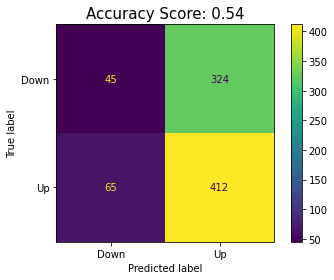

In [97]:
# let's use a confusion matrix to easily evaluate results 
from sklearn.metrics import confusion_matrix as cm, ConfusionMatrixDisplay
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
confusion_matrix_obj = ConfusionMatrixDisplay(cm1, display_labels=['Down', 'Up'])
confusion_matrix_obj.plot()
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

In [ ]:
# let's use a confusion matrix to easily evaluate results 
from sklearn.metrics import confusion_matrix as cm, ConfusionMatrixDisplay
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
confusion_matrix_obj = ConfusionMatrixDisplay(cm1, display_labels=['Down', 'Up'])
confusion_matrix_obj.plot()
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

<AxesSubplot:>

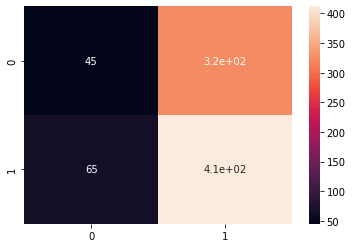

In [98]:
import seaborn as sns
sns.heatmap(cm1, annot=True)